# Bloch-point domain wall

This notebook is written by Marijan Beg (University of Southampton) in order to document some basic finmag functionality to reproduce the BPDW reported in APL 102, 112405 (2013).

## Relaxing the system to BPDW state

First of all, we need to import everything we need from finmag.

In [3]:
from finmag import Simulation as Sim
from finmag.energies import Exchange, Demag
from finmag.util.meshes import nanodisk
from finmag.util.consts import mu0

In the next step, we define all material and geometric parameters.

In [4]:
# Material parameters.

Ms = 8.6e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)

# Geometric parameters.
L = 1000  # nanowire length (nm)
d = 50  # nanowire diameter (nm)

Please note that both `L` and `d` are given in nm, not meters (50 instead of 50e-9). The reason for this will be addressed later.

Knowing the material parameters, we can compute the exchange length which would help us determine what discretisation to choose. The exchange length is:

$$l_\text{ex} = \sqrt{\frac{2A}{\mu_{0}M_\text{s}^{2}}}$$

In [5]:
import numpy as np

# Exchange length.
lex = np.sqrt(2*A / (mu0*Ms**2))

print 'Exchange length is', lex

Exchange length is 5.28911842031e-09


Accordingly, I will choose the discretisation to be 5 nm. More precisely, this is the maximum distance allowed between two neghbouring nodes in the finite elements mesh. This value can be reduced for better resolution, but this increases the running time.

So, the mesh can be created using a `nanodisk` function, where arguments are:

- nanowire diameter
- nanowire length
- discretisation
- save resulting mesh file

I will choose not to save the mesh files, that is why `save_result=False`.

In [6]:
lmax = 5

mesh = nanodisk(d, L, lmax, save_result=False)

[2016-06-24 11:41:56] DEBUG: Using netgen to convert /tmp/tmpJSZPdx.geo to DIFFPACK format.
[2016-06-24 11:42:08] WARNING: Warning: Ignoring netgen's output status of 34304.
[2016-06-24 11:42:08] DEBUG: Done!
[2016-06-24 11:42:08] DEBUG: Using dolfin-convert to convert /tmp/tmpJSZPdx.grid to xml format.
[2016-06-24 11:42:09] DEBUG: Compressing /tmp/tmpJSZPdx.xml
[2016-06-24 11:42:10] DEBUG: Removing file '/tmp/tmpJSZPdx.xml.gz' because mesh is created on the fly.
[2016-06-24 11:42:10] DEBUG: Removing file '/tmp/tmpJSZPdx.geo' because mesh is created on the fly.


The simulation object is created by passing the mesh, saturation magnetisation, and the unit length. Because we defined `L` and `d` in meters, we need to pass the `unit_length` parameter to be 1e-9 (1nm).

In [7]:
sim = Sim(mesh, Ms, unit_length=1e-9)

[2016-06-24 11:43:18] INFO: Finmag logging output will be written to file: '/home/mb4e10/tmp/bpdw/unnamed.log' (any old content will be overwritten).
[2016-06-24 11:43:18] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2016-06-24 11:43:18] INFO: Creating Sim object name='unnamed', instance_id=0 (rank=0/1).
[2016-06-24 11:43:18] DEBUG:    Total number of Sim objects in this session: 1
[2016-06-24 11:43:18] INFO: <Mesh of topological dimension 3 (tetrahedra) with 12488 vertices and 50884 cells, ordered>
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in __init__::LLG.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
[2016-06-24 11:43:18] DEBUG: Creating LLG object.
/home/mb4e10/finmag/src/finmag/util/helpers.py:1821: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  v2d_xxx = ((v2d_xyz.reshape(n1/dim, dim)).transpose()).reshape(-1,)


Our Hamiltonian contains only exchange and demagnetisation energy contributions. We can add these energies to the simulation by running:

In [8]:
sim.add(Exchange(A))
sim.add(Demag())

[2016-06-24 11:45:27] DEBUG: Creating Exchange object with method box-matrix-petsc, in Jacobian.
[2016-06-24 11:45:27] DEBUG: Adding interaction Exchange to simulation.
[2016-06-24 11:45:27] DEBUG: Creating Demag object with solver 'FK'.
[2016-06-24 11:45:27] DEBUG: Adding interaction Demag to simulation.
[2016-06-24 11:45:28] DEBUG: Using Krylov solver for demag.
[2016-06-24 11:45:38] DEBUG: Boundary element matrix uses 396.06 MB of memory.


Please note that Exchange energy requires the exchange energy constant A to be passed, whereas the demagnetisation energy does not have any parameters (Ms was already provided in the simulation object).

### Tricky part

Before we relax the system, we need to initialise it. Let's imagine that the system is initialised in the (0, 0, 1) direction. Please note that the nanowire is elongated in the z direction.

In [9]:
sim.set_m((0, 0, 1))

Finally, we can relax the system.

In [10]:
sim.relax()

[2016-06-24 11:47:10] INFO: Simulation will run until relaxation of the magnetisation.
[2016-06-24 11:47:10] DEBUG: Relaxation parameters: stopping_dmdt=1.0 (degrees per nanosecond), dt_limit=1e-10, dmdt_increased_counter_limit=10
[2016-06-24 11:47:10] INFO: Creating integrator with backend sundials and arguments {'reltol': 1e-06, 'abstol': 1e-06}.
[2016-06-24 11:47:10] DEBUG: Updating get method for steps in TableWriter(name=unnamed.ndt)
[2016-06-24 11:47:10] DEBUG: Updating get method for last_step_dt in TableWriter(name=unnamed.ndt)
[2016-06-24 11:47:10] DEBUG: Updating get method for dmdt in TableWriter(name=unnamed.ndt)
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in compute_field::Exchange.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in compute_field::FKDemag.
  warnings.warn("You are nesting me

After the system is relaxed, we can save the relaxed state to the pvd file and analyse it using Paraview (http://www.paraview.org/).

In [11]:
sim.save_vtk('relaxed_state1.pvd', overwrite=True)

[2016-06-24 11:50:21] WARNING: Removing file 'relaxed_state1.pvd' and all associated .vtu files (because overwrite=True).
[2016-06-24 11:50:21] DEBUG: Saved field at t=3.2445482928e-10 to file 'relaxed_state1.pvd' (snapshot #0; saving took 0.155 seconds).


If we open that file in Paraview, we can see that no domain wall is present in the sample. More precisely, energy minimisation from the (0, 0, 1) state does not result in domain wall. Because of that, we need to initialise our system differently.

I will initialise it so that the lower half of nanowire ($z < L/2$) is magnetised in the (0, 0, 1) direction, and the upper hald in the opposite (0, 0, -1) direction. This can be written using a Python function, which is then passed as an argument to the `set_m` method.

In [12]:
def m_init(pos):
    x, y, z = pos
    if z < L/2.:
        return (0, 0, 1)
    else:
        return (0, 0, -1)

sim.set_m(m_init)

[2016-06-24 12:00:47] DEBUG: Re-initialising CVODE integrator.


How we initialised the system, can be checked using Paraview by opening the `initial_state.pvd` file, that we save in the next step.

In [13]:
sim.set_m(m_init)

[2016-06-24 12:02:18] DEBUG: Re-initialising CVODE integrator.


Finally, we can relax the system. Please be patient, this relexation can take some time.

In [14]:
sim.reset_time(0)
sim.relax()

[2016-06-24 12:02:28] INFO: Creating integrator with backend sundials and arguments {'t0': 0}.
[2016-06-24 12:02:28] INFO: Simulation will run until relaxation of the magnetisation.
[2016-06-24 12:02:28] DEBUG: Relaxation parameters: stopping_dmdt=1.0 (degrees per nanosecond), dt_limit=1e-10, dmdt_increased_counter_limit=10
[2016-06-24 12:02:31] DEBUG: At t=2e-14, last_dmdt=7.49e+03 * stopping_dmdt, next dt=1e-14.
[2016-06-24 12:02:31] DEBUG: At t=3e-14, last_dmdt=7.56e+03 * stopping_dmdt, next dt=1e-14.
[2016-06-24 12:02:32] DEBUG: At t=4e-14, last_dmdt=7.62e+03 * stopping_dmdt, next dt=1e-14.
[2016-06-24 12:02:32] DEBUG: At t=5e-14, last_dmdt=7.69e+03 * stopping_dmdt, next dt=1e-14.
[2016-06-24 12:02:32] DEBUG: At t=6e-14, last_dmdt=7.76e+03 * stopping_dmdt, next dt=1e-14.
[2016-06-24 12:02:33] DEBUG: At t=7e-14, last_dmdt=7.82e+03 * stopping_dmdt, next dt=1e-14.
[2016-06-24 12:02:33] DEBUG: At t=8e-14, last_dmdt=7.89e+03 * stopping_dmdt, next dt=1e-14.
[2016-06-24 12:02:34] DEBUG: A

We save the pvd file and open it with Paraview.

In [15]:
sim.save_vtk('relaxed_state2.pvd', overwrite=True)

[2016-06-24 12:17:36] WARNING: Removing file 'relaxed_state2.pvd' and all associated .vtu files (because overwrite=True).
[2016-06-24 12:17:36] DEBUG: Saved field at t=1.02113763469e-09 to file 'relaxed_state2.pvd' (snapshot #0; saving took 0.151 seconds).


Now, we obtained the BPDW!

We can plot the domain wall profile by sampling the magnetisation along the nanowire centre (0, 0, z).

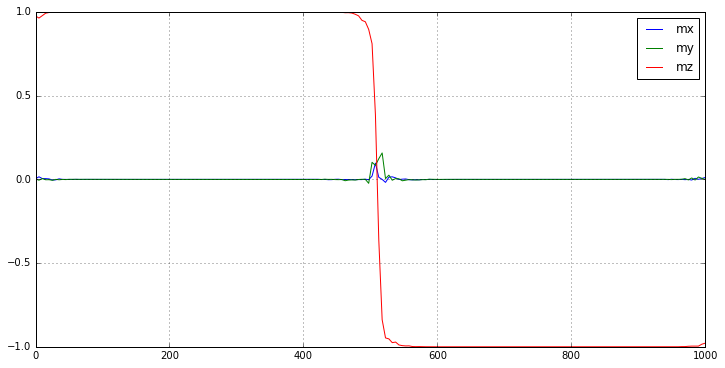

In [17]:
def dw_profile():
    z_array = np.linspace(0, L, 200)
    mx = []
    my = []
    mz = []
    for z in z_array:
        point = (0, 0, z)
        m = sim.llg.m_field.f(point)
        mx.append(m[0])
        my.append(m[1])
        mz.append(m[2])
  
    return z_array, mx, my, mz
    
z_array, mx, my, mz = dw_profile()


# Plot the profile.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(z_array, mx, label='mx')
plt.plot(z_array, my, label='my')
plt.plot(z_array, mz, label='mz')
plt.legend()
plt.grid()
plt.show()

By analysing this profile, we can coclude that the domain wall position can be defined as a z coorindte where $m_{z}\approx0$.

In [18]:
def dw_position(z_array, mz):
    return z_array[np.where(np.abs(mz)==np.abs(mz).min())[0]][0]

dw_position(z_array, mz)

512.56281407035181

Accordingly, the domain wall position is at $z=512.56 \,\text{nm}$.

## Moving domain wall using external field

We can now apply an external magnetic field, apply it along the nanowire and track how the domain wall moves. Let's apply B=100 mT field in the (0, 0, 1) direction. Accordingly, the field is:

In [19]:
B = 100e-3  # (T)
H = (0, 0, B/mu0)

from finmag.energies import Zeeman
sim.add(Zeeman(H))

[2016-06-24 12:30:43] DEBUG: Adding interaction Zeeman to simulation.


Now, we will run the time evolution and record the magnetisation every $20 \,\text{ps}$ for $0.2 \,\text{ns}$.

In [20]:
T = 0.2e-9
dt = 20e-12

dw = []
t_array = np.arange(0, T, dt)
sim.reset_time(0)
for t in t_array:
    sim.run_until(t)
    z_array, mx, my, mz = dw_profile()
    dw.append(dw_position(z_array, mz))

[2016-06-24 12:33:21] INFO: Creating integrator with backend sundials and arguments {'t0': 0}.
[2016-06-24 12:33:21] INFO: Simulation will run until t = 0 s.
[2016-06-24 12:33:21] INFO: Simulation has reached time t = 0 s.
[2016-06-24 12:33:21] INFO: Simulation will run until t = 2e-11 s.
[2016-06-24 12:33:37] INFO: Simulation has reached time t = 2e-11 s.
[2016-06-24 12:33:37] INFO: Simulation will run until t = 4e-11 s.
[2016-06-24 12:33:45] INFO: Simulation has reached time t = 4e-11 s.
[2016-06-24 12:33:45] INFO: Simulation will run until t = 6e-11 s.
[2016-06-24 12:33:58] INFO: Simulation has reached time t = 6e-11 s.
[2016-06-24 12:33:58] INFO: Simulation will run until t = 8e-11 s.
[2016-06-24 12:34:14] INFO: Simulation has reached time t = 8e-11 s.
[2016-06-24 12:34:14] INFO: Simulation will run until t = 1e-10 s.
[2016-06-24 12:34:30] INFO: Simulation has reached time t = 1e-10 s.
[2016-06-24 12:34:30] INFO: Simulation will run until t = 1.2e-10 s.
[2016-06-24 12:34:46] INFO: 

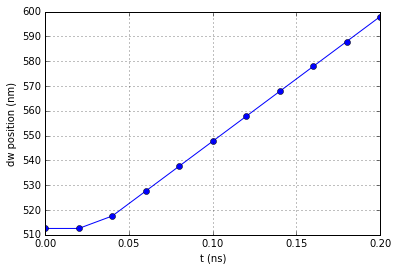

In [21]:
plt.plot(t_array/1e-9, dw, 'o-')
plt.xlabel('t (ns)')
plt.ylabel('dw position (nm)')
plt.grid()
plt.show()

Domain wall velocity can now be extracted from the slope of the plot (first derivative).

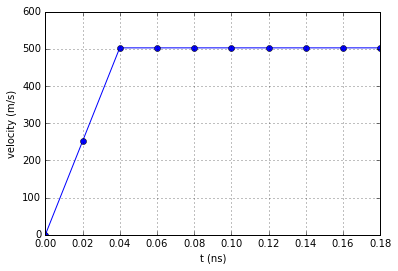

In [22]:
velocity = []
for i in range(len(dw)-1):
    v = (dw[i+1] - dw[i])*1e-9 / dt
    velocity.append(v)

plt.plot(t_array[0:-1]/1e-9, velocity, 'o-')
plt.xlabel('t (ns)')
plt.ylabel('velocity (m/s)')
plt.grid()
plt.show()